# Figure 4

Effect size vs. behavioral data

In [1]:
from datetime import datetime
from pathlib import Path

import colorcet as cc
import matplotlib
import numpy as np
import pandas as pd
import scipy
import seaborn as sb
from cycler import cycler
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import analysis
from analysis import SESSIONS
from load import load_preprocessed_data
from metadata import METADATA

In [2]:
# Register tqdm with pandas for `progress_apply`
tqdm.pandas()

In [3]:
# Color palette
PALETTE = np.array(cc.b_glasbey_category10[:5])[
    [2, 4, 0, 1, 3]
]
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', PALETTE)

In [4]:
OUTPUT_DIR = Path('figures')

## Load data

In [5]:
main = pd.read_parquet("results/main.parquet")

In [6]:
# Unscrambled vs. scrambled
subset = main.loc[
    main["stimulus_is_scrambled_pair"]
]
subset.shape

(2200, 28)

## Effect size

In [7]:
response = "log(normalized differentiation)"

In [8]:
effect_size = (
    subset
    .groupby("session")
    .progress_apply(
        analysis.cohens_d,
        a='natural',
        b='artificial',
        value_col=response,
        label_col="stimulus_type",
    )
)

  0%|          | 0/44 [00:00<?, ?it/s]

In [9]:
effect_size.to_parquet("results/effect_size.parquet")

In [10]:
effect_size = effect_size.merge(METADATA, on="session")

## Load behavioral data

In [11]:
loaded_data = Parallel(n_jobs=len(SESSIONS), verbose=5)(
    delayed(load_preprocessed_data)(session) for session in SESSIONS
)

dff, data = zip(*loaded_data)

[Parallel(n_jobs=44)]: Using backend LokyBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done   2 out of  44 | elapsed:    6.4s remaining:  2.3min
[Parallel(n_jobs=44)]: Done  11 out of  44 | elapsed:    9.1s remaining:   27.4s
[Parallel(n_jobs=44)]: Done  20 out of  44 | elapsed:   11.8s remaining:   14.1s
[Parallel(n_jobs=44)]: Done  29 out of  44 | elapsed:   15.9s remaining:    8.2s
[Parallel(n_jobs=44)]: Done  38 out of  44 | elapsed:   21.0s remaining:    3.3s
[Parallel(n_jobs=44)]: Done  44 out of  44 | elapsed:   24.8s finished


## Compute mean pupil diameter and locomotion fraction

In [12]:
# All areas and layers
behavior = (
    pd.concat(data)
    .reset_index()
    .loc[:, ["session", "normalized_pupil_diameter", "filtered_velocity", "locomotion"]]
    .groupby("session")
    .mean()
    .rename(
        columns={
            "normalized_pupil_diameter": "pupil diameter",
            "locomotion": "locomotion fraction",
        }
    )
    .merge(effect_size, on="session")
)

In [13]:
# L2/3 of AL & AM
behavior_subset = behavior.loc[
    (behavior.layer == 'L2/3') &
    (behavior.area.isin(['AL', 'AM']))
]

## Plot

In [14]:
output_dir = OUTPUT_DIR / "fig-4"

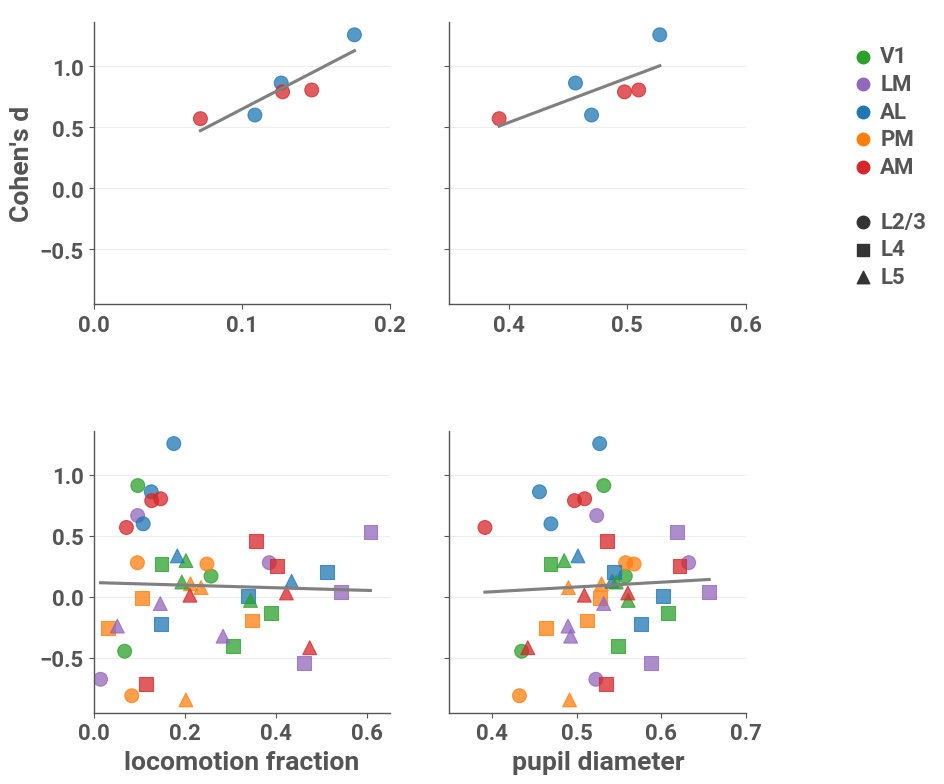

In [15]:
figsize = (8, 8)
fig, ax = plt.subplots(2, 2, sharey=True, figsize=figsize)

y = "Cohen's d"


def scatter(ax, x, y, data, **kwargs):
    kwargs = {
        **dict(
            hue="area",
            style="layer",
            s=100,
            alpha=0.75,
            edgecolor=None,
            markers={
                "L2/3": "o",
                "L4": "s",
                "L5": "^",
            },
            hue_order=[
                "V1",
                "LM",
                "AL",
                "PM",
                "AM",
            ],
        ),
        **kwargs,
    }
    return sb.scatterplot(ax=ax, x=x, y=y, data=data, **kwargs)


sb.regplot(
    ax=ax[0, 0],
    color="grey",
    ci=None,
    scatter=False,
    x="locomotion fraction",
    y=y,
    data=behavior_subset,
)
sb.regplot(
    ax=ax[0, 1],
    color="grey",
    ci=None,
    scatter=False,
    x="pupil diameter",
    y=y,
    data=behavior_subset,
)
sb.regplot(
    ax=ax[1, 0],
    color="grey",
    ci=None,
    scatter=False,
    x="locomotion fraction",
    y=y,
    data=behavior,
)
sb.regplot(
    ax=ax[1, 1],
    color="grey",
    ci=None,
    scatter=False,
    x="pupil diameter",
    y=y,
    data=behavior,
)


scatter(ax=ax[0, 0], x="locomotion fraction", y=y, data=behavior_subset)
scatter(ax=ax[0, 1], x="pupil diameter", y=y, data=behavior_subset)
scatter(ax=ax[1, 0], x="locomotion fraction", y=y, data=behavior)
scatter(ax=ax[1, 1], x="pupil diameter", y=y, data=behavior)

for axis in ax[0]:
    axis.set_xlabel(None)

for axis in ax[:, 1]:
    axis.set_ylabel(None)
ax[1, 0].set_ylabel(None)

for axis in ax.flat:
    axis.get_legend().remove()

ax[0, 0].set_xlim(0, 0.2)
ax[0, 0].set_xticks([0, 0.1, 0.2])
ax[1, 0].set_xlim(0, 0.65)
ax[1, 0].set_xticks([0, 0.2, 0.4, 0.6])
ax[0, 1].set_xlim(0.35, 0.55)
ax[0, 1].set_xticks([0.4, 0.5, 0.6])
ax[1, 1].set_xlim(0.35, 0.7)
ax[1, 1].set_xticks([0.4, 0.5, 0.6, 0.7])

handles, labels = ax[1, 1].get_legend_handles_labels()
labels[0] = ""
labels[-4] = ""
legend = fig.legend(
    handles=handles,
    labels=labels,
    bbox_to_anchor=(1.2, 1),
    labelspacing=0.25,
    markerscale=1.5,
    ncol=1,
    handletextpad=-0.25,
)

fig.tight_layout()
fig.subplots_adjust(hspace=0.45, wspace=0.2)

# Write to disk
analysis.savefig(
    fig,
    output_dir / "effect_size_vs_behavior.png",
    bbox_extra_artists=[legend],
)

fig.show()

## Statistical testing

### Set up R and prepare data

In [16]:
%load_ext rpy2.ipython

In [17]:
data = behavior.loc[:, [
    "Cohen's d",
    "area",
    "layer",
    "pupil diameter",
    "locomotion fraction",
]].rename(columns={
    "Cohen's d": 'cohens_d',
    "locomotion fraction": 'locomotion_fraction',
    "pupil diameter": 'pupil_diameter',
})

In [18]:
data_subset = data.loc[
    (data['layer'] == 'L2/3') &
    (data['area'].isin(['AL', 'AM']))
]

### Test

In [19]:
%%R -i data_subset

cor.test(
    data_subset$locomotion_fraction, 
    data_subset$cohens_d, 
    method = 'pearson',
    alternative = "two.sided",
)


	Pearson's product-moment correlation

data:  data_subset$locomotion_fraction and data_subset$cohens_d
t = 4.0296, df = 4, p-value = 0.01574
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3082942 0.9886237
sample estimates:
      cor 
0.8957413 



In [20]:
%%R -i data_subset

cor.test(
    data_subset$pupil_diameter, 
    data_subset$cohens_d, 
    method = 'pearson',
    alternative = "two.sided", 
)


	Pearson's product-moment correlation

data:  data_subset$pupil_diameter and data_subset$cohens_d
t = 2.0537, df = 4, p-value = 0.1092
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2273095  0.9662081
sample estimates:
      cor 
0.7164124 



In [21]:
%%R -i data

cor.test(
    data$locomotion_fraction, 
    data$cohens_d, 
    method = 'pearson',
    alternative = "two.sided",
)


	Pearson's product-moment correlation

data:  data$locomotion_fraction and data$cohens_d
t = -0.22046, df = 42, p-value = 0.8266
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3275718  0.2655631
sample estimates:
        cor 
-0.03399766 



In [22]:
%%R -i data

cor.test(
    data$pupil_diameter, 
    data$cohens_d, 
    method = 'pearson',
    alternative = "two.sided", 
)


	Pearson's product-moment correlation

data:  data$pupil_diameter and data$cohens_d
t = 0.30215, df = 42, p-value = 0.764
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2538175  0.3387687
sample estimates:
       cor 
0.04657225 

